In [22]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable


In [6]:

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

# Load data

In [2]:
def load_formatted_data(path):
    loaded_data={
        'metadata':pd.read_hdf(path,key='metadata'),
        'spectra':pd.read_hdf(path,key='spectra')
    }

    with h5py.File(
      path,
      'r'
    ) as file:
        loaded_data['wvl'] = file['wvl'][()]

    return(loaded_data)


dataset_chemcam = load_formatted_data('datasets/chemcam_extended2015_v_a.h5')

In [3]:
list(dataset_chemcam.keys())

['metadata', 'spectra', 'wvl']

In [4]:
spectra = dataset_chemcam['spectra']
spectra = spectra.iloc[:,1:]
metadata = dataset_chemcam['metadata']
wavelengths = dataset_chemcam['wvl']
wavelengths = wavelengths[1:]

#data.shape
ground_truth = metadata.loc[:,'SiO2':'K2O']


ground_truth = ground_truth.drop(['FeT', 'FeO', 'Fe2O3'] , axis = 1)
ground_truth = ground_truth.drop(ground_truth.columns[[3]], axis=1)


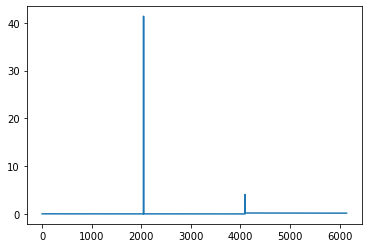

In [7]:
x = wavelengths
differences = [x[i+1]-x[i] for i in range(len(x)-1)]

unique_differences = list(set(differences))
wavelengths
plt.plot(differences)

In [17]:
ech_grid = np.arange(200.00, 1000.00, 0.02)
ech_grid.shape

(40000,)

In [21]:
from scipy.interpolate import interp1d
ech_grid = np.arange(200.00, 1000.00, 0.02)
ech_grid.shape


mask_bound = ~((ech_grid >= wavelengths.min()) & (ech_grid <= wavelengths.max()))
mask_1gap = (ech_grid >= 339) & (ech_grid <= 383)
mask_2gap = (ech_grid >= 468) & (ech_grid <= 474)
mask = mask_bound | mask_1gap | mask_2gap

# mask_plot = 1*mask 
# plt.plot(mask_plot)
ech_grid = ech_grid[~mask]

# interpolate the signal to the new time grid using linear interpolation
f = interp1d(wavelengths, spectra, kind='linear')
spectra_ech = f(ech_grid)

# K-means

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.



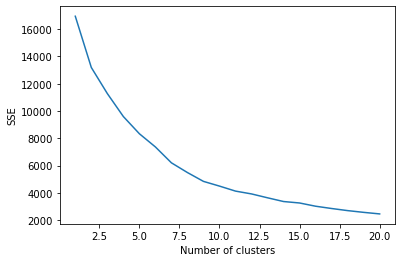

In [60]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Load data

# Replace NaNs with zeros
data = ground_truth.fillna(0)

# Standardize data
standardized_data = (data - data.mean()) / data.std()



from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Compute SSE for different values of k
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_data)
    sse.append(kmeans.inertia_)

# Plot SSE vs. number of clusters
plt.plot(range(1, 21), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# PCA of composition

In [80]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Load data

# Replace NaNs with zeros
data = ground_truth.fillna(0)

# Standardize data
standardized_data = (data - data.mean(axis = 0))/ data.std(axis = 0)





# Perform k-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(standardized_data)


# Perform PCA
pca = PCA()
pca.fit(standardized_data)

# Create scores plot
scores = pca.transform(standardized_data)
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
scores_df['Cluster'] = labels.astype(str)
scores_fig = px.scatter(scores_df, x='PC1', y='PC2', color='Cluster')

# Create loadings plot
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'], index=data.columns)
loadings_fig = go.Figure(data=[go.Bar(x=loadings_df.index, y=loadings_df['PC1'])])
loadings_fig.update_layout(xaxis_tickangle=-90)

# Show plots
scores_fig.show()
loadings_fig.show()

# Count the number of samples in each cluster
counts = pd.Series(kmeans.labels_).value_counts()
print(counts)


3    600
1    440
5    298
7    185
2    160
0    105
6     50
4     30
8     10
9      5
dtype: int64


# Resample to echelle

# Train network